In this code, we have used ResNet model with 1,4,4,1 blocks for 4 

---

layers, output channels for each convolution layer are 64,96,128,512. Learning rate = 0.05, momentum = 0.9, weight decay = 0.00001, optimizer - Adam

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
import torchvision

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time
import gc

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)


100%|██████████| 170498071/170498071 [00:01<00:00, 101084851.87it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
VALID_RATIO = 0.9

n_train_examples = int(len(trainset) * VALID_RATIO)
n_valid_examples = len(trainset) - n_train_examples

trainset, validset = data.random_split(trainset, 
                                           [n_train_examples, n_valid_examples])

In [5]:
valid_data = copy.deepcopy(validset)
valid_data.dataset.transform = transform_test

In [6]:
def plot_images(images, labels, classes, normalize = False):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image_min = image.min()
            image_max = image.max()
            image.clamp_(min = image_min, max = image_max)
            image.add_(-image_min).div_(image_max - image_min + 1e-5)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

In [7]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [trainset[i] for i in range(N_IMAGES)]])

classes = testset.classes

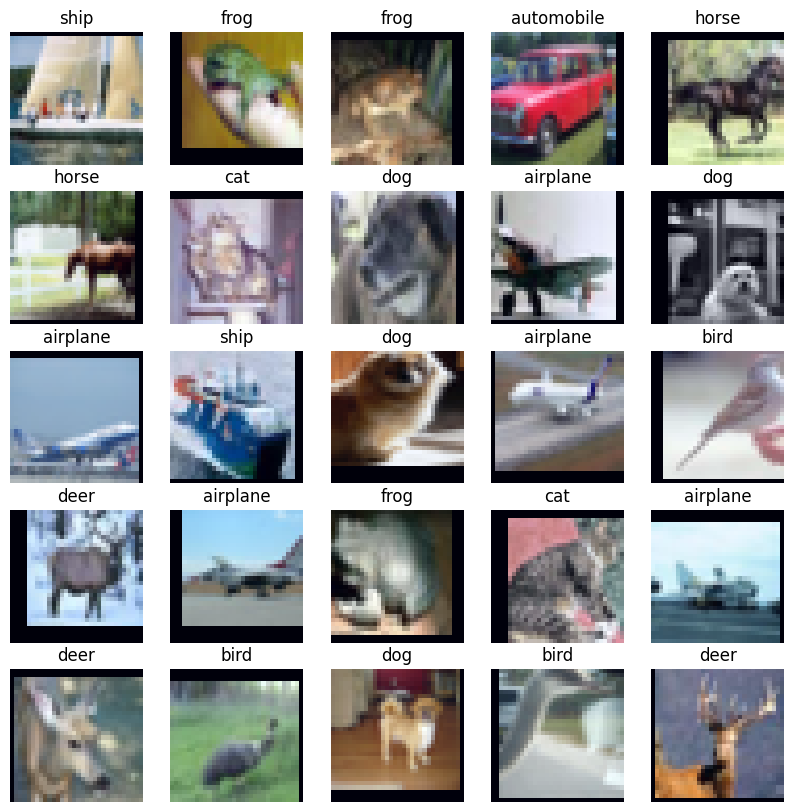

In [8]:
plot_images(images, labels, classes, normalize = True)

In [9]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [11]:
class Block(nn.Module):

    def __init__(self, input_channels, output_channels, stride = 1, downsample = None):
        super(Block, self).__init__()

        # conv1
        self.conv1 = nn.Sequential(
                        nn.Conv2d(input_channels, output_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(output_channels),
                        nn.ReLU())
        
        # conv2
        self.conv2 = nn.Sequential(
                        nn.Conv2d(output_channels, output_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(output_channels))
        
        # skip connection
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.output_channels = output_channels

    def forward(self, x):
        identity = x
        out = self.conv2(self.conv1(x))

        if self.downsample:
            identity = self.downsample(x)
        
        out += identity
        out = self.relu(out)
        
        return out

In [12]:
class ResNet(nn.Module):
    def __init__(self, block, num_classes = 10):
        super(ResNet, self).__init__()
        self.input_channels = 64

        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 1, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())

        self.layer0 = self._make_layer(block, 64, 1, stride = 1)
        self.layer1 = self._make_layer(block, 96, 4, stride = 2)
        self.layer2 = self._make_layer(block, 128, 4, stride = 2)
        self.layer3 = self._make_layer(block, 512, 1, stride = 2)

        self.avgpool = nn.AvgPool2d(4, stride=1)
        self.fc = nn.Linear(512, num_classes)
        self.droupout = nn.Dropout(p=0.05)

    def _make_layer(self, block, output_channels, block_num, stride=1):
        downsample = None

        if stride != 1:
            downsample = nn.Sequential(
                            nn.Conv2d(self.input_channels, output_channels, kernel_size=1, stride=stride),
                            nn.BatchNorm2d(output_channels))
        
        layers = []
        layers.append(block(self.input_channels, output_channels, stride, downsample))
        self.input_channels = output_channels

        for i in range(1, block_num):
            layers.append(block(self.input_channels, output_channels))

        return nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.droupout(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [13]:
from torchsummary import summary
model = ResNet(Block, 10).to(device)

summary(model, (3, 32, 32),device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,472
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,928
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
            Block-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 96, 16, 16]          55,392
      BatchNorm2d-12           [-1, 96, 16, 16]             192
             ReLU-13           [-1, 96, 16, 16]               0
           Conv2d-14           [-1, 96,

In [14]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [17]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.05, weight_decay=1e-5)

In [18]:
TRAIN_ACC = []
TEST_ACC = []
TRAIN_LOSS = []
TEST_LOSS = []

In [19]:
NUM_EMPOCHS = 70
BEST_ACC = 0

for epoch in range(NUM_EMPOCHS):
    start_time = time.time()
    batch_loss = 0
    n_correct = 0
    n_samples = 0
    model.train()
    # train
    for i, (images, labels) in enumerate(trainloader):  
        images = images.to(device)
        labels = labels.to(device)
        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        # cal loss and acc
        batch_loss += loss.item()
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del images, labels, outputs

    elapsed_mins, elapsed_secs = epoch_time(start_time, time.time())
    acc_train = 100.0 * n_correct / n_samples
    loss_train = batch_loss/len(trainloader)
    TRAIN_ACC.append(acc_train)
    TRAIN_LOSS.append(loss_train)
    print(f"Epoch {epoch + 1:02}/{NUM_EMPOCHS} | {elapsed_mins}m{elapsed_secs}s:")
    print(f"    Train Loss: {loss_train:.4f}, train Acc: {acc_train:.4f}%")
# test
    with torch.no_grad():
        correct = 0
        total = 0
        batch_loss = 0
        model.eval()
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            # cal loss and acc
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            batch_loss += loss.item()
            del images, labels, outputs
            
        acc_test = 100 * correct / total
        loss_test = batch_loss/len(testloader)
        TEST_ACC.append(acc_test)
        TEST_LOSS.append(loss_test)
        print(f"    Test  Loss: {loss_test:.4f}, test  Acc: {acc_test:.4f}%")
    
        # save model
        file = "model_" + str(epoch+1) + ".pth"
        if(acc_test > BEST_ACC):
            BEST_ACC = acc_test
            torch.save(model.state_dict(), file)
            
    
    torch.cuda.empty_cache()
    gc.collect()

Epoch 01/70 | 0m41s:
    Train Loss: 2.0145, train Acc: 23.6960%
    Test  Loss: 1.9684, test  Acc: 31.4900%
Epoch 02/70 | 0m39s:
    Train Loss: 1.6671, train Acc: 37.1300%
    Test  Loss: 1.7655, test  Acc: 37.5400%
Epoch 03/70 | 0m38s:
    Train Loss: 1.4824, train Acc: 45.4040%
    Test  Loss: 1.9698, test  Acc: 37.7300%
Epoch 04/70 | 0m38s:
    Train Loss: 1.3203, train Acc: 52.1780%
    Test  Loss: 1.8696, test  Acc: 41.8400%
Epoch 05/70 | 0m37s:
    Train Loss: 1.2237, train Acc: 55.7960%
    Test  Loss: 1.3431, test  Acc: 50.2900%
Epoch 06/70 | 0m37s:
    Train Loss: 1.1589, train Acc: 58.4880%
    Test  Loss: 1.2398, test  Acc: 56.8500%
Epoch 07/70 | 0m37s:
    Train Loss: 1.1262, train Acc: 59.6800%
    Test  Loss: 1.3544, test  Acc: 54.8100%
Epoch 08/70 | 0m36s:
    Train Loss: 1.0927, train Acc: 60.8620%
    Test  Loss: 1.0592, test  Acc: 64.0400%
Epoch 09/70 | 0m37s:
    Train Loss: 1.0620, train Acc: 62.2320%
    Test  Loss: 1.5027, test  Acc: 53.8300%
Epoch 10/70 | 0m37s

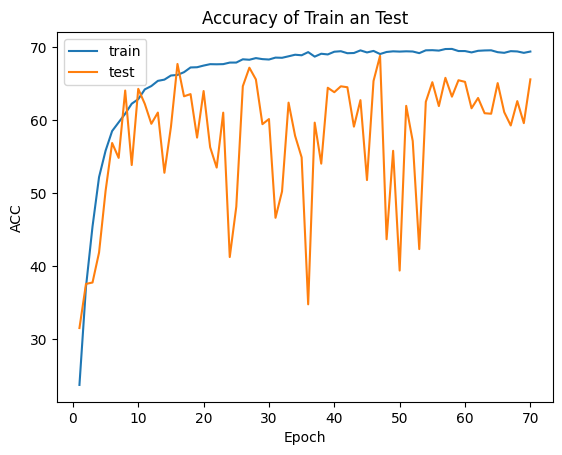

In [20]:
EPOCHS = [i for i in range(1,71)]
plt.plot(EPOCHS, TRAIN_ACC)
plt.plot(EPOCHS, TEST_ACC)
plt.xlabel('Epoch')
plt.ylabel('ACC')
plt.legend(['train', 'test'], loc='upper left')
plt.title("Accuracy of Train an Test")
plt.show()

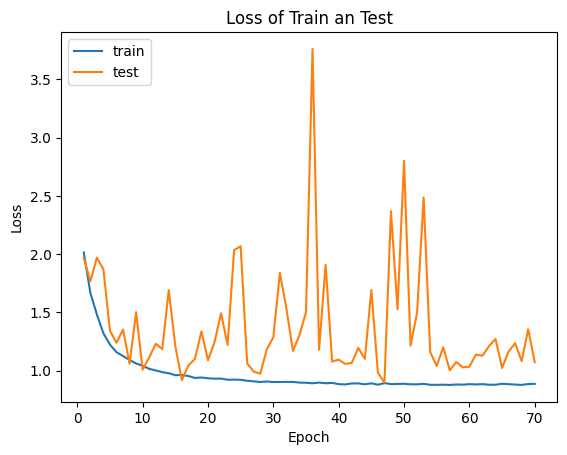

In [21]:
plt.plot(EPOCHS, TRAIN_LOSS)
plt.plot(EPOCHS, TEST_LOSS)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.title("Loss of Train an Test")
plt.show()